In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("./archive (4)/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [2]:
import os
import librosa
import librosa.display

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [5]:
# Audio Playback (Optional)
import IPython.display as ipd

# Resampling Library
import resampy  

from tqdm.auto import tqdm

In [6]:
dat1, sampling_rate1 = librosa.load('./archive (4)/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('./archive (4)/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

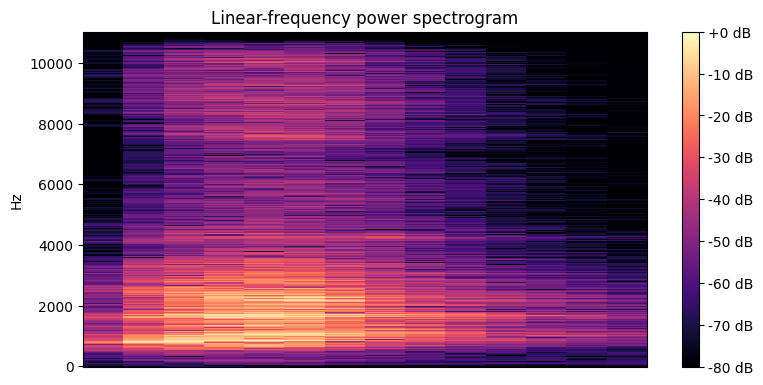

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Register Matplotlib Converters for Time Series Plots
pd.plotting.register_matplotlib_converters()
%matplotlib inline  
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

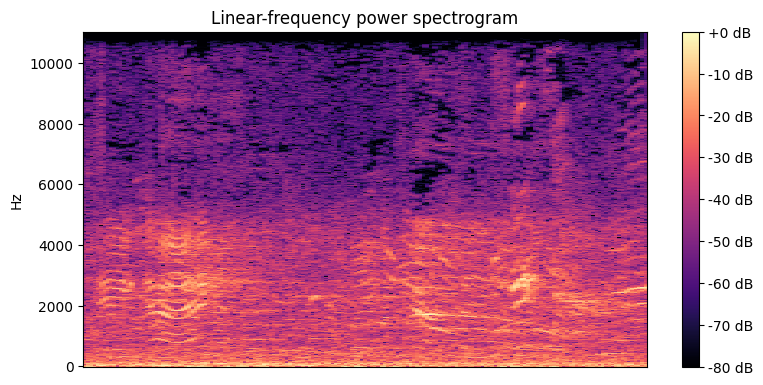

In [8]:
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

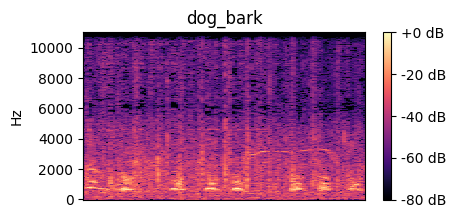

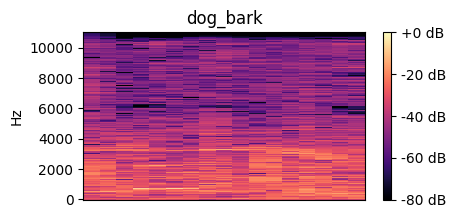

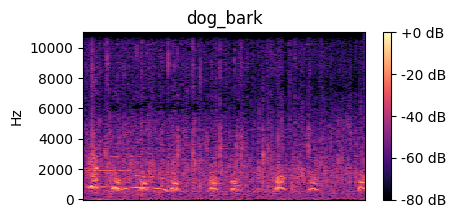

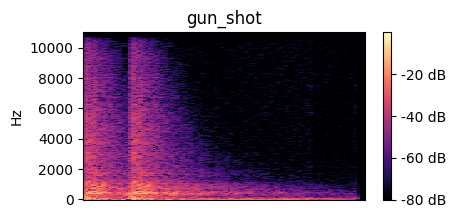

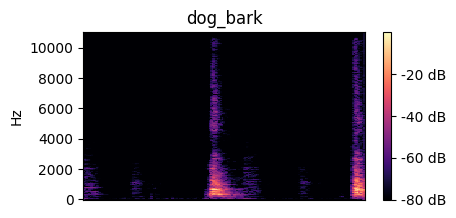

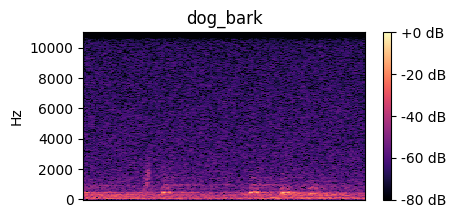

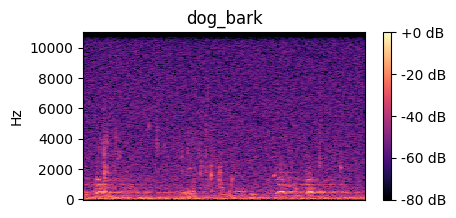

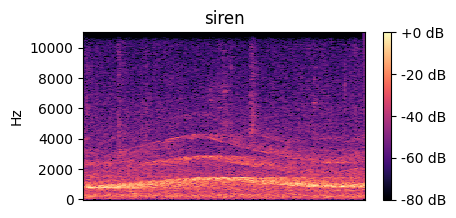

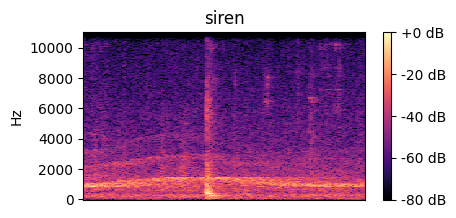

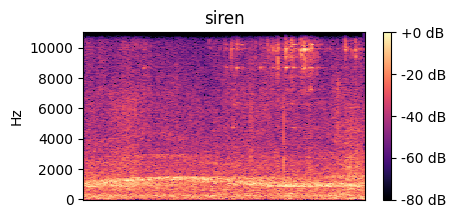

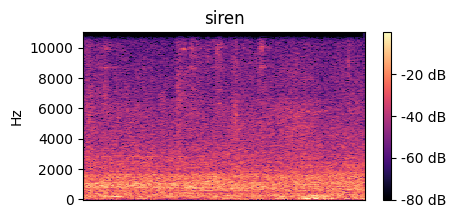

In [9]:
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(100, 121, 2):
    path = './archive (4)/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [10]:
# First restart kernel 
print("Librosa version:", librosa.__version__)
print("Resampy version:", resampy.__version__)

Librosa version: 0.10.2.post1
Resampy version: 0.4.3


In [20]:
def features_extract(file_name):
    sample, sample_rate = librosa.load(file_name, sr=22050, res_type='kaiser_fast')  # Uses resampy
    feature = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=50, n_fft=1024, fmax=sample_rate / 2)
    scaled_feature = np.mean(feature.T, axis=0)
    return scaled_feature

extracted = []
path = './archive (4)'

for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(path),'fold'+str(row["fold"])+'/',str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data= features_extract(file_name)    
    extracted.append([data,final_class_labels])

0it [00:00, ?it/s]

In [21]:
ext_df = pd.DataFrame(extracted,columns=['feature','class'])
ext_df

,feature,class
0,"[-302.21152, 69.556465, -124.388756, -50.66138...",dog_bark
1,"[-497.49588, 108.53252, -52.183617, 60.615326,...",children_playing
2,"[-531.8105, 120.17569, -46.226433, 51.953545, ...",children_playing
3,"[-488.22928, 102.17729, -34.55252, 53.13045, 1...",children_playing
4,"[-519.3341, 112.80471, -52.25847, 60.23233, 2....",children_playing
...,...,...
8727,"[-470.80038, 134.84998, -50.82176, 35.83541, -...",car_horn
8728,"[-419.70996, 86.23215, -44.575157, 52.246014, ...",car_horn
8729,"[-375.78317, 112.08009, -46.08013, 35.412975, ...",car_horn
8730,"[-415.52222, 125.33423, -54.730793, 34.484978,...",car_horn


In [22]:
x = np.array(ext_df['feature'].tolist())
y = np.array(ext_df['class'].tolist())
le = LabelEncoder()

y = to_categorical(le.fit_transform(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [23]:
from tensorflow.keras.layers import Input

num_labels = y.shape[1]
model = Sequential([
    Input(shape=(50,)),  
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'), 

    Dense(num_labels, activation='softmax')  
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 128)                 │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,530 (545.04 KB)

 Trainable params: 139,530 (545.04 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [29]:
history = model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=100,
          validation_data=(x_test, y_test),
         )

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8004 - loss: 0.6374 - val_accuracy: 0.8683 - val_loss: 0.4702
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8024 - loss: 0.6221 - val_accuracy: 0.8666 - val_loss: 0.4665
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8100 - loss: 0.6146 - val_accuracy: 0.8695 - val_loss: 0.4602
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7978 - loss: 0.6223 - val_accuracy: 0.8661 - val_loss: 0.4697
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7896 - loss: 0.6601 - val_accuracy: 0.8626 - val_loss: 0.4698
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7948 - loss: 0.6273 - val_accuracy: 0.8661 - val_loss: 0.4668
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8066 - loss: 0.6307 - val_accuracy: 0.8695 - val_loss: 0.4827
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 0.6713 - val_accu

KeyboardInterrupt: 

In [26]:
def showAccVallLossPlt(history):
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

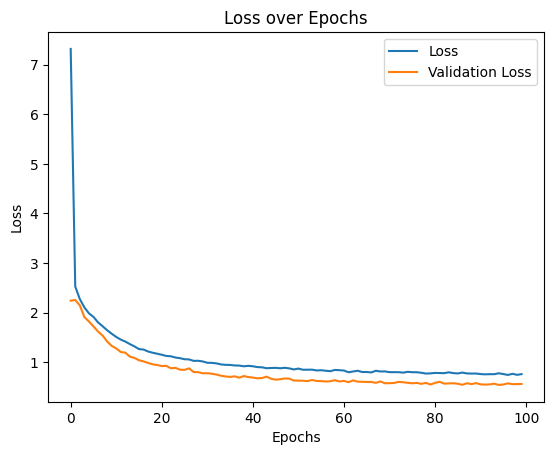

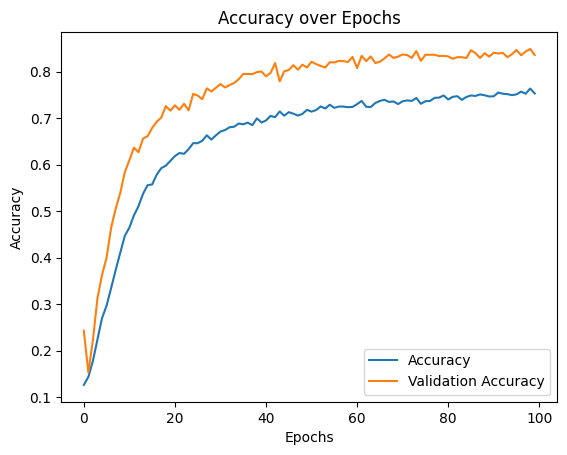

In [27]:
showAccVallLossPlt(history)

In [28]:
history2 = model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=200,
          validation_data=(x_test, y_test),
         )

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7540 - loss: 0.7396 - val_accuracy: 0.8414 - val_loss: 0.5424
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7669 - loss: 0.7154 - val_accuracy: 0.8409 - val_loss: 0.5375
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7617 - loss: 0.7324 - val_accuracy: 0.8495 - val_loss: 0.5135
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7557 - loss: 0.7502 - val_accuracy: 0.8443 - val_loss: 0.5493
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7606 - loss: 0.7426 - val_accuracy: 0.8472 - val_loss: 0.5649
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7659 - loss: 0.7280 - val_accuracy: 0.8489 - val_loss: 0.5386
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.7466 - val_accuracy: 0.8460 - val_loss: 0.5385
Epoch 8/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7550 - loss: 0.7496 - val_accu

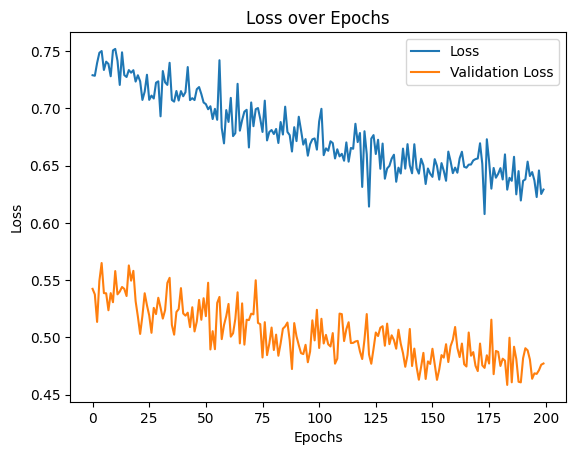

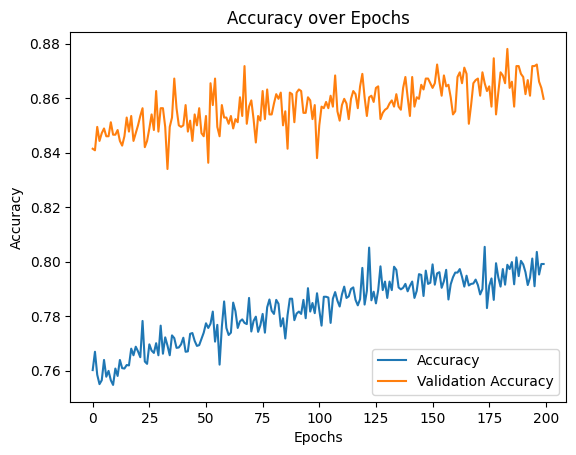

In [30]:
showAccVallLossPlt(history2)

Epoch 1/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8104 - loss: 0.5937 - val_accuracy: 0.8741 - val_loss: 0.4368
Epoch 2/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8100 - loss: 0.5950 - val_accuracy: 0.8729 - val_loss: 0.4406
Epoch 3/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8061 - loss: 0.6068 - val_accuracy: 0.8735 - val_loss: 0.4436
Epoch 4/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8047 - loss: 0.5917 - val_accuracy: 0.8752 - val_loss: 0.4317
Epoch 5/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8159 - loss: 0.5675 - val_accuracy: 0.8689 - val_loss: 0.4468
Epoch 6/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8062 - loss: 0.5860 - val_accuracy: 0.8666 - val_loss: 0.4445
Epoch 7/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8142 - loss: 0.5844 - val_accuracy: 0.8775 - val_loss: 0.4354
Epoch 8/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8147 - loss: 0.5979 - val_accu

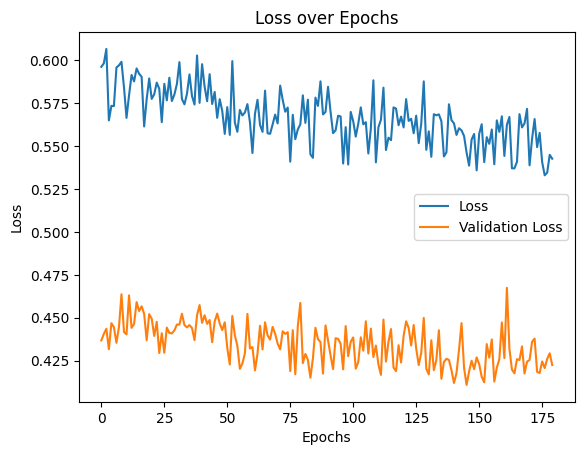

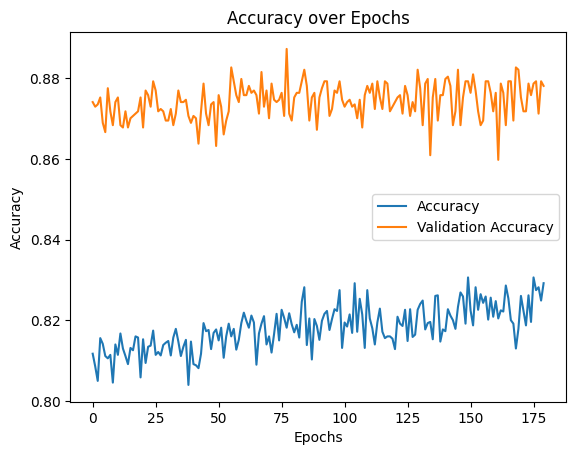

In [31]:
history3 = model.fit(
          x_train, 
          y_train, 
          batch_size=64, 
          epochs=180,
          validation_data=(x_test, y_test),
         )
showAccVallLossPlt(history3)

CNN

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

num_labels = y.shape[1]
modelConv = Sequential([
    Input(shape=(50, 1)), 
    
    Conv1D(64, 3, activation='relu'), 
    MaxPooling1D(2),  

    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),

    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(2),

    Flatten(),  

    Dense(128, activation='relu'),  
    Dropout(0.5),
    Dense(num_labels, activation='softmax')  
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 128)                 │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,592 (1.60 MB)

 Trainable params: 139,530 (545.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 279,062 (1.06 MB)

In [ ]:
modelConv.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history4 = modelConv.fit(
          x_train, 
          y_train, 
          epochs=180,
          validation_data=(x_test, y_test),
         )
showAccVallLossPlt(history4)

Epoch 1/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3145 - loss: 2.1552 - val_accuracy: 0.6136 - val_loss: 1.1500
Epoch 2/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5565 - loss: 1.2827 - val_accuracy: 0.7167 - val_loss: 0.8455
Epoch 3/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6641 - loss: 0.9759 - val_accuracy: 0.7733 - val_loss: 0.7367
Epoch 4/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7358 - loss: 0.7761 - val_accuracy: 0.8128 - val_loss: 0.5928
Epoch 5/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7806 - loss: 0.6568 - val_accuracy: 0.8437 - val_loss: 0.4854
Epoch 6/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8155 - loss: 0.5537 - val_accuracy: 0.8369 - val_loss: 0.4886
Epoch 7/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8401 - loss: 0.4729 - val_accuracy: 0.8632 - val_loss: 0.4468
Epoch 8/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8496 - loss: 0.4246 - val_accu

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history5=modelConv.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=180, callbacks=[early_stopping])
showAccVallLossPlt(history5)

In [ ]:
from tensorflow.keras.layers import BatchNormalization

num_labels = y.shape[1]
modelConv2 = Sequential([
    Input(shape=(50, 1)), 
    
    Conv1D(64, 3, activation='relu'), 
    MaxPooling1D(2),
    BatchNormalization(),  #
    
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Flatten(),
    
    Dense(256, activation='relu'),  
    Dropout(0.5),
    Dense(128, activation='relu'),  
    Dropout(0.5),
    
    Dense(num_labels, activation='softmax')
])

modelConv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelConv2.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history6 = modelConv2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=32,callbacks=[early_stopping])
showAccVallLossPlt(history6)

In [ ]:
early_stop2 = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history7 = modelConv2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=32,callbacks=[early_stop2])
showAccVallLossPlt(history7)

In [ ]:
def extract_feature(file_name):
    audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    fea = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
    scaled = np.mean(fea.T,axis=0)
    return np.array([scaled])
def print_prediction(file_name):
    pred_fea = extract_feature(file_name) 
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n') 

In [ ]:
df

In [ ]:
print_prediction('./archive (4)/fold1/101415-3-0-3.wav')
ipd.Audio('./archive (4)/fold1/101415-3-0-3.wav')

In [ ]:
print_prediction('./archive (4)/fold10/100648-1-2-0.wav')
ipd.Audio('./archive (4)/fold10/100648-1-2-0.wav')

In [ ]:
print_prediction('./archive (4)/fold3/103199-4-0-3.wav')
ipd.Audio('./archive (4)/fold3/103199-4-0-3.wav')